### Import

In [1]:
import sys
sys.path.insert(0, '../Src/')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.losses import CategoricalCrossentropy
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2, l1
from keras.metrics import Accuracy, SparseCategoricalAccuracy, CategoricalAccuracy, AUC, \
    PrecisionAtRecall, Recall, Precision, F1Score

from Model_maintenance import modelMaintenance

### Load data

Load dataframe

In [3]:
df_train = pd.read_csv('..\data\predictive_maintenance_train_resampled.csv')
df_test = pd.read_csv('..\data\predictive_maintenance_test_resampled.csv')
df_val = pd.read_csv('..\data\predictive_maintenance_validation.csv')

Extract the name of variable of 'Target'

In [4]:
name_target_col = list(filter(lambda ligne: 'Failure' in ligne, df_train.columns))
name_target_col

['No Failure', 'With_Failure']

Split to train and test data
Separation of explanatory variables and variables to identify

In [5]:
X_train = df_train.drop(columns=name_target_col)
y_train = df_train[name_target_col]
X_test = df_test.drop(columns=name_target_col)
y_test = df_test[name_target_col]
X_val = df_val.drop(columns=name_target_col)
y_val = df_val[name_target_col]

In [6]:
num_features = X_train.shape[1] # Nombre de variables explicatives
num_target = y_train.shape[1]   # Nombre de variables cibles

In [7]:

keras.backend.clear_session()


### Create model

In [8]:


model = modelMaintenance(
    num_layers=5, 
    num_input=num_features, 
    num_output=num_target,
    loss=CategoricalCrossentropy(),
    optimizer='adam',#Adam(5e-4),
    metrics=[CategoricalAccuracy(), Precision(), Recall()])#,AUC(), F1Score()])

In [ ]:
model.plot_model()

### Training Model

In [9]:
model.train(X_train.to_numpy(), y_train.to_numpy(), X_test.to_numpy(), y_test.to_numpy(), batch_size=256, epochs=100, verbose=1)

Epoch 1/100

25/25 [==============================] - 3s 89ms/step - loss: 0.5997 - categorical_accuracy: 0.5852 - precision: 0.5851 - recall: 0.5849 - val_loss: 0.6095 - val_categorical_accuracy: 0.7268 - val_precision: 0.7268 - val_recall: 0.7268 - lr: 0.0010
Epoch 2/100
 2/25 [=>............................] - ETA: 1s - loss: 0.4307 - categorical_accuracy: 0.7031 - precision: 0.7031 - recall: 0.7031

c:\Users\yanni\anaconda3\envs\Predictive_maintenance_project\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 2s 77ms/step - loss: 0.4473 - categorical_accuracy: 0.7842 - precision: 0.7842 - recall: 0.7842 - val_loss: 0.5307 - val_categorical_accuracy: 0.7469 - val_precision: 0.7469 - val_recall: 0.7469 - lr: 0.0010
Epoch 3/100
25/25 [==============================] - 2s 91ms/step - loss: 0.4079 - categorical_accuracy: 0.8231 - precision: 0.8231 - recall: 0.8231 - val_loss: 0.4695 - val_categorical_accuracy: 0.7707 - val_precision: 0.7707 - val_recall: 0.7707 - lr: 0.0010
Epoch 4/100
25/25 [==============================] - 2s 78ms/step - loss: 0.3582 - categorical_accuracy: 0.8159 - precision: 0.8159 - recall: 0.8159 - val_loss: 0.2917 - val_categorical_accuracy: 0.8534 - val_precision: 0.8534 - val_recall: 0.8534 - lr: 0.0010
Epoch 5/100
25/25 [==============================] - 2s 84ms/step - loss: 0.3294 - categorical_accuracy: 0.8359 - precision: 0.8359 - recall: 0.8359 - val_loss: 0.3129 - val_categorical_accuracy: 0.8465 - val_precision: 0.8465 - 

In [ ]:
model.plot_history()

50/50 [==============================] - 0s 7ms/step
Confusion matrix, without normalization
[[1336  207]
 [   3   50]]


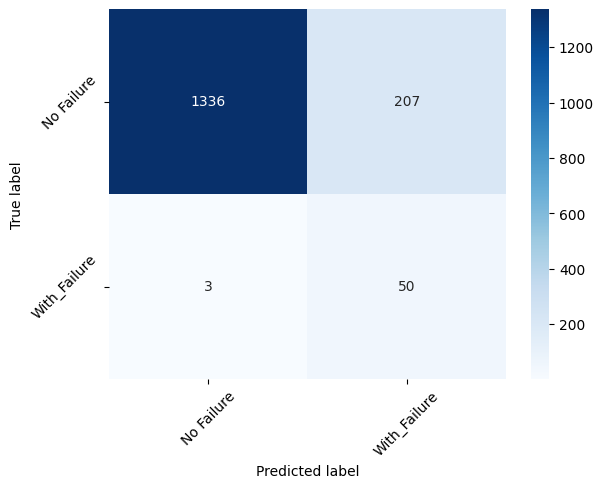

In [11]:
y_pred_test = model.predict(X_test.to_numpy())
model.plot_confusion_matrix(y_test.to_numpy().argmax(axis=1), y_pred_test.argmax(axis=1), name_target_col)

63/63 [==============================] - 0s 6ms/step
Confusion matrix, without normalization
[[1668  261]
 [   4   62]]


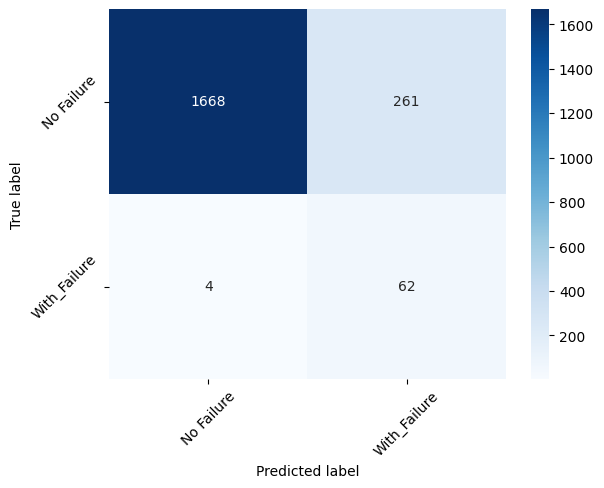

In [10]:
y_pred_val = model.predict(X_val.to_numpy())
model.plot_confusion_matrix(y_val.to_numpy().argmax(axis=1), y_pred_val.argmax(axis=1), name_target_col)

In [13]:
res, score_details = model.print_evaluation(X_val.to_numpy(), y_val.to_numpy(), y_pred_val>0.5, verbose=0)


63/63 - 1s - loss: 0.2476 - categorical_accuracy: 0.8672 - precision: 0.8672 - recall: 0.8672 - 1s/epoch - 23ms/step


In [14]:

df_score = pd.DataFrame()
df_score = pd.concat([df_score, pd.DataFrame(score_details, index=[0])], axis=0)
df_score

,loss,categorical_accuracy,precision,recall,kappa,F1_score
0,0.247644,0.867168,0.867168,0.867168,0.734336,0.867168


### Training multiple model

In [15]:
score = {}
df_score = pd.DataFrame()

for i in range(1,8,1):

    keras.backend.clear_session()
    
    model = modelMaintenance(
        num_layers=i, 
        num_input=num_features, 
        num_output=num_target,
        loss=CategoricalCrossentropy(),
        optimizer='adam',#Adam(5e-4),
        metrics=[CategoricalAccuracy(), AUC(),  Precision(), Recall()])
    
    model.train(X_train.to_numpy(), y_train.to_numpy(), X_test.to_numpy(), y_test.to_numpy(), batch_size=256, epochs=100, verbose=0)

    y_pred_val = model.predict(X_val.to_numpy())

    print('Nombre de couches : ', i)
    score[i], score_details = model.print_evaluation(X_val.to_numpy(), y_val.to_numpy(), y_pred_val>0.5, verbose=0)
    
    df_score = pd.concat([df_score, pd.DataFrame(score_details, index=[i])], axis=0)
    print('')

    

c:\Users\yanni\anaconda3\envs\Predictive_maintenance_project\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63/63 [==============================] - 0s 3ms/step
Nombre de couches :  1
63/63 - 2s - loss: 0.3291 - categorical_accuracy: 0.8662 - auc: 0.9356 - precision: 0.8662 - recall: 0.8662 - 2s/epoch - 25ms/step



c:\Users\yanni\anaconda3\envs\Predictive_maintenance_project\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63/63 [==============================] - 0s 3ms/step
Nombre de couches :  2
63/63 - 1s - loss: 0.3146 - categorical_accuracy: 0.8677 - auc: 0.9390 - precision: 0.8677 - recall: 0.8677 - 1s/epoch - 23ms/step



c:\Users\yanni\anaconda3\envs\Predictive_maintenance_project\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63/63 [==============================] - 0s 4ms/step
Nombre de couches :  3
63/63 - 2s - loss: 0.2668 - categorical_accuracy: 0.8752 - auc: 0.9564 - precision: 0.8752 - recall: 0.8752 - 2s/epoch - 27ms/step



c:\Users\yanni\anaconda3\envs\Predictive_maintenance_project\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63/63 [==============================] - 0s 5ms/step
Nombre de couches :  4
63/63 - 2s - loss: 0.1766 - categorical_accuracy: 0.9078 - auc: 0.9810 - precision: 0.9078 - recall: 0.9078 - 2s/epoch - 29ms/step



c:\Users\yanni\anaconda3\envs\Predictive_maintenance_project\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63/63 [==============================] - 0s 6ms/step
Nombre de couches :  5
63/63 - 2s - loss: 0.1703 - categorical_accuracy: 0.9103 - auc: 0.9843 - precision: 0.9103 - recall: 0.9103 - 2s/epoch - 29ms/step



c:\Users\yanni\anaconda3\envs\Predictive_maintenance_project\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63/63 [==============================] - 0s 6ms/step
Nombre de couches :  6
63/63 - 2s - loss: 0.2689 - categorical_accuracy: 0.8451 - auc: 0.9566 - precision: 0.8451 - recall: 0.8451 - 2s/epoch - 29ms/step



c:\Users\yanni\anaconda3\envs\Predictive_maintenance_project\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63/63 [==============================] - 1s 8ms/step
Nombre de couches :  7
63/63 - 2s - loss: 0.2650 - categorical_accuracy: 0.8566 - auc: 0.9576 - precision: 0.8566 - recall: 0.8566 - 2s/epoch - 29ms/step



In [16]:
df_score.columns.drop('loss')

Index(['categorical_accuracy', 'auc', 'precision', 'recall', 'kappa',
       'F1_score'],
      dtype='object')

In [17]:
#df_score.style.background_gradient(cmap='viridis')
df_score.style.highlight_max(color = 'blue', subset=df_score.columns.drop('loss')).highlight_min(color = 'green', subset=['loss'])
#df_score.style.highlight_min(color = 'blue', subset=['loss'])
#display(df_score)

,loss,categorical_accuracy,auc,precision,recall,kappa,F1_score
1,0.329066,0.866165,0.935632,0.866165,0.866165,0.732331,0.866165
2,0.314604,0.867669,0.939008,0.867669,0.867669,0.735338,0.867669
3,0.266841,0.875188,0.956359,0.875188,0.875188,0.750376,0.875188
4,0.176553,0.907769,0.980981,0.907769,0.907769,0.815539,0.907769
5,0.170327,0.910276,0.984346,0.910276,0.910276,0.820551,0.910276
6,0.268867,0.845113,0.956624,0.845113,0.845113,0.690226,0.845113
7,0.264954,0.856642,0.957636,0.856642,0.856642,0.713283,0.856642
